In [2]:
import os
import time
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [3]:
path='/home/s0852603/dlmia_final/train.csv'

In [4]:
train_detail=pd.read_csv(path)
train_detail=np.array(train_detail)

In [5]:
train_detail

array([['000c1434d8d7', 2],
       ['001639a390f0', 4],
       ['0024cdab0c1e', 1],
       ...,
       ['ffcf7b45f213', 2],
       ['ffd97f8cd5aa', 0],
       ['ffec9a18a3ce', 2]], dtype=object)

In [6]:
fp=[]
for i in range(3662):
    fp.append('/home/s0852603/dlmia_final/train_images/'+train_detail[:,0][i]+'.png')

In [7]:
n=3662

In [8]:
x=[]
IMG_SIZE = 512
for i in tqdm(range(n)):
    a = cv2.imread(fp[i])
    a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    a = cv2.resize(a, (IMG_SIZE, IMG_SIZE))
    x.append(a)

100%|██████████| 3662/3662 [04:13<00:00, 14.44it/s]


In [9]:
x=np.array(x)

In [10]:
y=train_detail[:,1].astype('float')

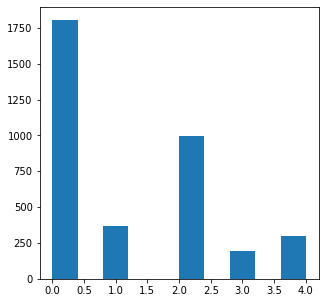

In [11]:
fig=plt.figure(figsize=(5,5))
plt.hist(y)
plt.show();

In [12]:
len(x),len(y)

(3662, 3662)

In [13]:
xx,yy=x[0:n],y[0:n]
len(xx),len(yy)

(3662, 3662)

In [14]:
class ImgDataset(Dataset):
    def __init__(self, x, y=None, transform=None):
        self.x = x
        self.y = y
        if y is not None:
            self.y = torch.LongTensor(y)
        self.transform = transform
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        X = self.x[index]
        if self.transform is not None:
            X = self.transform(X)
            #X = X*255
        if self.y is not None:
            Y = self.y[index]
            return X, Y
        else:
            return X
    
    def get_batch(self, indices):
        images = []
        labels = []
        for index in indices:
            image, label = self.__getitem__(index)
            images.append(image)
            labels.append(label)
        
        return torch.stack(images), torch.tensor(labels)

In [15]:
size=(224,224)
data_transform_1={
    'train':transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.Resize(size),
    transforms.ToTensor()
    ]),
    'val':transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(size),
    transforms.ToTensor()
    ])}

In [117]:
class Resnet_v2(nn.Module):
    def __init__(self,n_classes):
        super().__init__()
        #freeze the preteained weight before fc.layer
        resnet50=models.resnet50(pretrained=True)
        frozen_layers=[resnet50.conv1,resnet50.bn1,resnet50.layer1]#,resnet50.layer2,resnet50.layer3]#,resnet50.layer4]#resnet50.layer2
        for layer in frozen_layers:
            for name,value in layer.named_parameters():
                value.requires_grad=False
        params = filter(lambda p: p.requires_grad, resnet50.parameters())
        #add new layer 
        resnet50.fc=nn.Sequential(
            nn.Dropout(p=0.25),
            nn.Linear(in_features=resnet50.fc.in_features,out_features=n_classes),
        )
        self.base_model=resnet50
        self.softmax=nn.Softmax(dim=1)

        
    def forward(self,x):
        return self.base_model(x)

In [95]:
train_x,valid_x,train_y,valid_y=train_test_split(xx,yy,test_size=0.2)

In [96]:
len(train_x),len(train_y),len(valid_x),len(valid_y)

(2929, 2929, 733, 733)

In [97]:
batch_size=64
train_set=ImgDataset(train_x,train_y,data_transform_1['train'])
val_set=ImgDataset(valid_x,valid_y,data_transform_1['val'])
train_loader=DataLoader(train_set,batch_size=batch_size,shuffle=True)
val_loader=DataLoader(val_set, batch_size=batch_size, shuffle=False)
dataloaders={'train':train_loader, 'val':val_loader}
dataset_sizes = {'train': train_set.__len__(), 'val': val_set.__len__()}

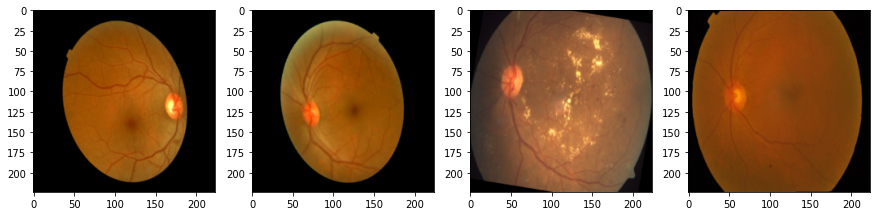

In [115]:
img_indices = [800, 300,550,700]
images , labels = train_set.get_batch(img_indices)
fig, axs = plt.subplots(1, len(img_indices), figsize=(15, 8))
for columns , target in enumerate(images):
    axs[columns].imshow((target).permute(1, 2, 0).numpy())
plt.show()
plt.close()

In [98]:
def train_model(model,criterion,optimizer,lr,num_epochs,wt_path,data_loader):
    
    since = time.time()
    best_acc = 0.0
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    dataloaders = data_loader
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        for phase in ['train', 'val']:
            running_loss = 0.0
            running_corrects = 0.0
            if phase == 'train':
                model.train()
                for data in dataloaders[phase]:
                    inputs, labels = data
                    if use_gpu :
                        inputs = inputs.to(device)
                        labels = torch.LongTensor(labels).to(device)
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    preds = torch.argmax(torch.softmax(outputs.data,dim=1),axis=1)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    #scheduler.step()
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                
                train_loss.append(running_loss / dataset_sizes[phase])
                train_acc.append(running_corrects.cpu() / dataset_sizes[phase])
            else:
                with torch.no_grad():
                    model.eval()
                    for data in dataloaders[phase]:
                        inputs, labels = data
                        if use_gpu:
                            inputs = inputs.to(device)
                            labels = torch.LongTensor(labels).to(device)
                        outputs = model(inputs)
                        preds = torch.argmax(torch.softmax(outputs.data,dim=1),axis=1)
                        loss = criterion(outputs, labels)
                        running_loss += loss.item() * inputs.size(0)
                        running_corrects += torch.sum(preds == labels.data)
                    
                    val_loss.append(running_loss / dataset_sizes[phase])
                    val_acc.append(running_corrects.cpu() / dataset_sizes[phase])
                    
                    if  (running_corrects/dataset_sizes[phase])>=(best_acc):
                        best_acc = running_corrects/dataset_sizes[phase]
                        print('Save_Weights!')
                        torch.save(model.state_dict(),wt_path)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

                    
        

            print('%sLoss: :%4f Acc: :%4f'%(phase, epoch_loss, epoch_acc))
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

In [116]:
LR=5e-6
EPOCHS=30
WEIGHT_DECAY = 1e-4
use_gpu=torch.cuda.is_available()
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
if use_gpu:
    model=Resnet_v2(5).to(device)
    train_loss=[]
    train_acc=[]
    val_loss=[]
    val_acc=[]
    criterion = nn.CrossEntropyLoss()
    optimizer_ft=torch.optim.Adam(model.parameters(),lr=LR,weight_decay = WEIGHT_DECAY)
    wt_path='/home/s0852603/can_delete.pt'

    train_model(model, criterion, optimizer_ft, lr=LR , num_epochs=EPOCHS, wt_path=wt_path ,data_loader=dataloaders)

Epoch 0/29
----------
trainLoss: :1.357870 Acc: :0.428474
Save_Weights!
valLoss: :1.114021 Acc: :0.660300
Epoch 1/29
----------
trainLoss: :0.953701 Acc: :0.708433
Save_Weights!
valLoss: :0.817249 Acc: :0.728513
Epoch 2/29
----------
trainLoss: :0.772785 Acc: :0.748378
Save_Weights!
valLoss: :0.720536 Acc: :0.733970
Epoch 3/29
----------
trainLoss: :0.682731 Acc: :0.763742
Save_Weights!
valLoss: :0.667859 Acc: :0.747613
Epoch 4/29
----------
trainLoss: :0.625104 Acc: :0.776716
Save_Weights!
valLoss: :0.628920 Acc: :0.757162
Epoch 5/29
----------
trainLoss: :0.583392 Acc: :0.779447
Save_Weights!
valLoss: :0.601939 Acc: :0.758527
Epoch 6/29
----------
trainLoss: :0.538953 Acc: :0.797542
Save_Weights!
valLoss: :0.576999 Acc: :0.770805
Epoch 7/29
----------
trainLoss: :0.510138 Acc: :0.810174
Save_Weights!
valLoss: :0.562602 Acc: :0.787176
Epoch 8/29
----------
trainLoss: :0.477733 Acc: :0.830317
Save_Weights!
valLoss: :0.544470 Acc: :0.796726
Epoch 9/29
----------
trainLoss: :0.449893 Acc

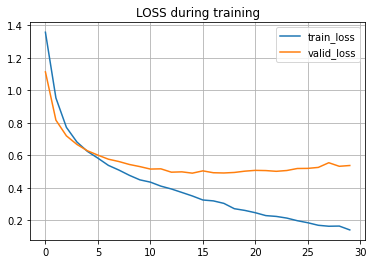

In [118]:
EPOCHES=30
epoch = np.array(range(EPOCHES))
plt.plot(epoch, train_loss, label="train_loss")
plt.plot(epoch, val_loss, label="valid_loss")
plt.title("LOSS during training")
plt.legend()
plt.grid()
plt.show();

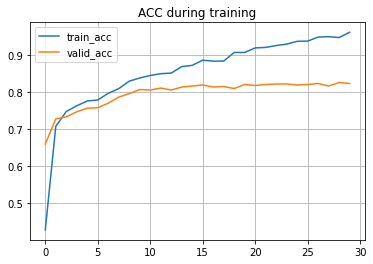

In [119]:
plt.plot(epoch, train_acc, label="train_acc")
plt.plot(epoch, val_acc, label="valid_acc")
plt.title("ACC during training")
plt.legend()
plt.grid()
plt.show();

In [127]:
torch.cuda.empty_cache()

In [121]:
#then turn to preprocessing
def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

In [122]:
 def load_ben_color(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

In [27]:
n=3662

In [28]:
ben_x=[]
for i in tqdm(range(n)):
    ben_x.append(load_ben_color(fp[i],sigmaX=30))

100%|██████████| 3662/3662 [12:06<00:00,  5.04it/s]


In [29]:
ben_x=np.array(ben_x)

In [69]:
ben_train_x,ben_valid_x,ben_train_y,ben_valid_y=train_test_split(ben_x,y,test_size=0.2)

In [70]:
len(ben_train_x),len(ben_train_y),len(ben_valid_x),len(ben_valid_y)

(2929, 2929, 733, 733)

In [123]:
batch_size=64
#sampler=WeightedRandomSampler([1,1,1,1],num_samples=1600,replacement=True)
ben_train_set=ImgDataset(ben_train_x,ben_train_y,data_transform_1['train'])
ben_val_set=ImgDataset(ben_valid_x,ben_valid_y,data_transform_1['val'])
ben_train_loader=DataLoader(ben_train_set,batch_size=batch_size,shuffle=True)#,sampler=sampler)
ben_val_loader=DataLoader(ben_val_set, batch_size=batch_size, shuffle=False)
ben_dataloaders={'train':ben_train_loader, 'val':ben_val_loader}
ben_dataset_sizes = {'train': ben_train_set.__len__(), 'val': ben_val_set.__len__()}

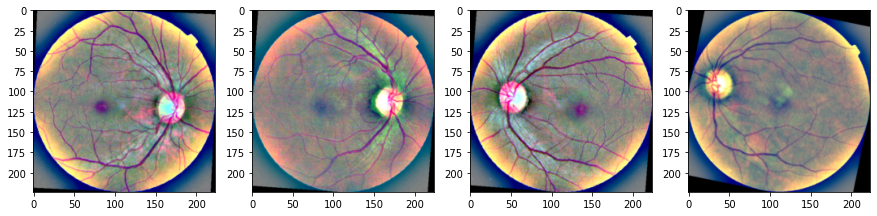

In [126]:
img_indices = [800, 300,550,700]
images , labels = ben_train_set.get_batch(img_indices)
fig, axs = plt.subplots(1, len(img_indices), figsize=(15, 8))
for columns , target in enumerate(images):
    axs[columns].imshow((target).permute(1, 2, 0).numpy())
plt.show()
plt.close()

In [128]:
LR=5e-6
EPOCHS=30
WEIGHT_DECAY = 1e-4
use_gpu=torch.cuda.is_available()
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
if use_gpu:
    model=Resnet_v2(5).to(device)
    train_loss=[]
    train_acc=[]
    val_loss=[]
    val_acc=[]
    criterion = nn.CrossEntropyLoss()
    optimizer_ft=torch.optim.Adam(model.parameters(),lr=LR,weight_decay = WEIGHT_DECAY)
    wt_path='/home/s0852603/ben_can_delete.pt'
    train_model(model, criterion, optimizer_ft, lr=LR , num_epochs=EPOCHS, wt_path=wt_path,data_loader=ben_dataloaders)

Epoch 0/29
----------
trainLoss: :1.468746 Acc: :0.374189
Save_Weights!
valLoss: :1.149757 Acc: :0.604366
Epoch 1/29
----------
trainLoss: :1.045135 Acc: :0.663708
Save_Weights!
valLoss: :0.833494 Acc: :0.755798
Epoch 2/29
----------
trainLoss: :0.846524 Acc: :0.725845
Save_Weights!
valLoss: :0.704838 Acc: :0.759891
Epoch 3/29
----------
trainLoss: :0.744366 Acc: :0.743599
Save_Weights!
valLoss: :0.639271 Acc: :0.768076
Epoch 4/29
----------
trainLoss: :0.673855 Acc: :0.759304
Save_Weights!
valLoss: :0.596191 Acc: :0.780355
Epoch 5/29
----------
trainLoss: :0.637824 Acc: :0.765790
Save_Weights!
valLoss: :0.563987 Acc: :0.788540
Epoch 6/29
----------
trainLoss: :0.591121 Acc: :0.780130
Save_Weights!
valLoss: :0.531105 Acc: :0.799454
Epoch 7/29
----------
trainLoss: :0.560681 Acc: :0.794811
Save_Weights!
valLoss: :0.515289 Acc: :0.813097
Epoch 8/29
----------
trainLoss: :0.529340 Acc: :0.805053
Save_Weights!
valLoss: :0.496092 Acc: :0.824011
Epoch 9/29
----------
trainLoss: :0.496825 Acc

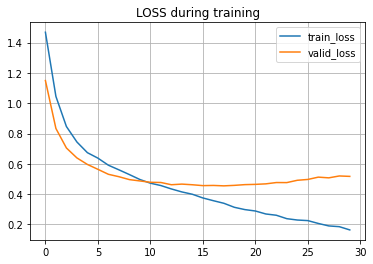

In [129]:
EPOCHES=30
epoch = np.array(range(EPOCHES))
plt.plot(epoch, train_loss, label="train_loss")
plt.plot(epoch, val_loss, label="valid_loss")
plt.title("LOSS during training")
plt.legend()
plt.grid()
plt.show();

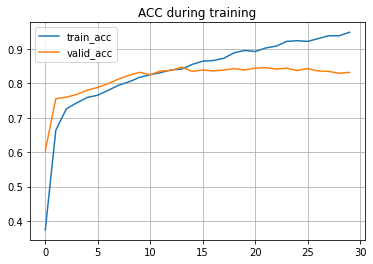

In [130]:
#ACC 相較之前上升5個百分點左右
plt.plot(epoch, train_acc, label="train_acc")
plt.plot(epoch, val_acc, label="valid_acc")
plt.title("ACC during training")
plt.legend()
plt.grid()
plt.show();